## CIS4930 -- Final Project
### Developed by: Chloe Fandino (Team Leader), Ashley James, Madelyne Wirbel, Chloe Nolan, Christopher Enlow

In [47]:
# imports here :)

# TODO: DELETE ---> any imports that don't end up getting used by the end of the project !!!!

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Loading the data

In [48]:
df = pd.read_csv('OnlineNewsPopularity.csv') # import the data from the csv file --> convert to df

### Exploration of the dataset

In [49]:
# pd.set_option('display.max_rows', 100) # for purposes of looking at data --> need to see all rows

# basic intitial looks at the dataset
print(df.shape)

print(df.info())

(39644, 61)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords       

In [50]:
print(df.columns.tolist()) # print out all of the available columns

['url', ' timedelta', ' n_tokens_title', ' n_tokens_content', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle', ' data_channel_is_entertainment', ' data_channel_is_bus', ' data_channel_is_socmed', ' data_channel_is_tech', ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min', ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares', ' self_reference_max_shares', ' self_reference_avg_sharess', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday', ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday', ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04', ' global_subjectivity', ' global_sentiment_polarity', ' global_rate_positive_words', ' global_rate_negative_words', ' rate_positive_words', '

In [51]:
df.isnull().sum() # null values? --> NONE :)

url                              0
 timedelta                       0
 n_tokens_title                  0
 n_tokens_content                0
 n_unique_tokens                 0
                                ..
 title_subjectivity              0
 title_sentiment_polarity        0
 abs_title_subjectivity          0
 abs_title_sentiment_polarity    0
 shares                          0
Length: 61, dtype: int64

In [52]:
df.duplicated().sum() # duplicate values? --> NONE :)

np.int64(0)

In [53]:
# check if any infinities exist in the dataframe
numeric_df = df.select_dtypes(include=[np.number])

has_inf = np.isinf(numeric_df.to_numpy()).any()

print(has_inf) # will need to handle in cleaning
inf_cols = numeric_df.columns[np.isinf(numeric_df.to_numpy()).any(axis=0)].tolist()
print("Columns with inf:", inf_cols)

False
Columns with inf: []


### Cleaning the data

In [54]:
# function with anomaly detection process --> first visualize, then calculate IQR
def anomaly_detection(feature):
    # first boxplot to see potential outliers
    sns.boxplot(x = df[feature], color = 'purple')
    plt.title(feature)
    plt.show()

    # second calculate outliers based on IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)

    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    anomalies = df[(df[feature] < lower) | (df[feature] > upper)]
    print('Anomalies: \n', anomalies) # prints a list of potential anomalies
    return

In [55]:
# exploration of potentially non-predictive features
df['url'].nunique() == len(df) # each example has a different url --> not needed in the dataset
df = df.drop(columns = ['url'])

df = df.drop(columns = [' timedelta']) # number of days since posted until added to the dataset --> no predictive qualities

Text(0.5, 1.0, 'Correlation Heatmap')

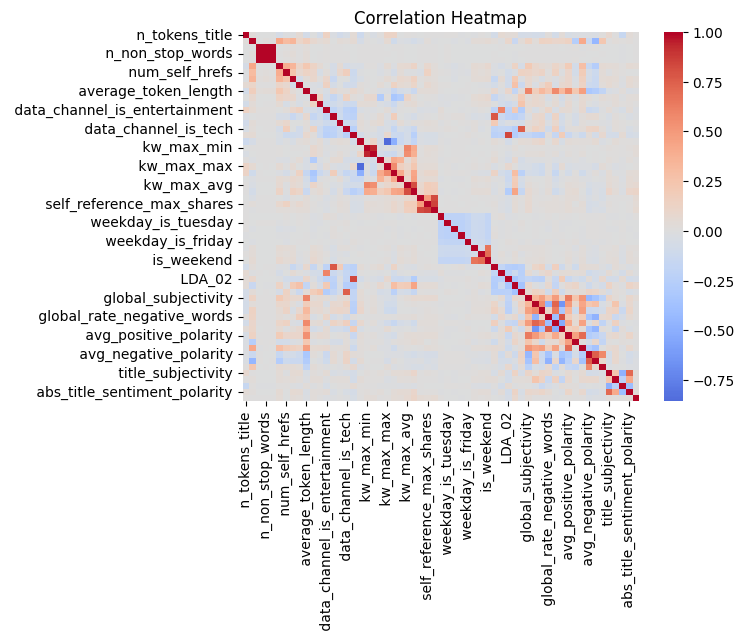

In [56]:
# test of feature correlation --> highly correlated features do not need to both be in dataser
df_correlation = df.corr()

sns.heatmap(df_correlation, cmap = 'coolwarm', center = 0)
plt.title("Correlation Heatmap")

In [57]:
# create a clone of the correlation matrix where you only keep the upper triangle --> no repeat values
upper_triangle = df_correlation.abs().where(
    np.triu(np.ones(df_correlation.abs().shape), k = 1).astype(bool)
)

# using threshold of 0.70 --> list columns that are redundant (but only one)
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.70)]

highly_correlated # print list

[' n_non_stop_words',
 ' n_non_stop_unique_tokens',
 ' kw_avg_min',
 ' kw_max_max',
 ' kw_avg_avg',
 ' self_reference_avg_sharess',
 ' is_weekend',
 ' LDA_00',
 ' LDA_02',
 ' LDA_04',
 ' rate_positive_words',
 ' rate_negative_words',
 ' max_positive_polarity',
 ' min_negative_polarity',
 ' abs_title_sentiment_polarity']

In [58]:
# drop highly correlated columns
df = df.drop(columns = [' n_non_stop_words',
 ' n_non_stop_unique_tokens',
 ' kw_avg_min',
 ' kw_max_max',
 ' kw_avg_avg',
 ' self_reference_avg_sharess',
 ' is_weekend',
 ' LDA_00',
 ' LDA_02',
 ' LDA_04',
 ' rate_positive_words',
 ' rate_negative_words',
 ' max_positive_polarity',
 ' min_negative_polarity',
 ' abs_title_sentiment_polarity'])

In [59]:
# ensure binary indicator columns are integers
df.columns = df.columns.str.strip()
binary_cols = [col for col in df.columns
               if col.startswith("data_channel_is_")
               or col.startswith("weekday_is_")]
print("Binary indicator columns:", binary_cols)

for col in binary_cols:
    df[col] = df[col].astype(int)

df[binary_cols].dtypes.head()

Binary indicator columns: ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday']


data_channel_is_lifestyle        int64
data_channel_is_entertainment    int64
data_channel_is_bus              int64
data_channel_is_socmed           int64
data_channel_is_tech             int64
dtype: object

In [60]:
# handling inf
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
print("Dataset shape after removing inf/NaN:", df.shape)

Dataset shape after removing inf/NaN: (39644, 44)


## Training and Testing

In [61]:
# separate features
y = df["shares"]
X = df.drop(columns = ["shares"])

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (39644, 43)
y shape: (39644,)


In [62]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

Training set: (31715, 43)
Test set: (7929, 43)


In [63]:
# scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
# train linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred = lin_reg.predict(X_test_scaled)

In [ ]:
# evaluate linear regression performance